In [18]:
!pip install prophet

# Commented out IPython magic to ensure Python compatibility.
#import library package
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.figure_factory as ff
import plotly.graph_objects as go
import numpy as np
import plotly.express as px
import re
import datetime as dt
from datetime import date
from datetime import timedelta
import gc
from tqdm import tqdm
from pylab import rcParams
from sklearn.metrics import mean_squared_error
from scipy.stats import probplot

import numpy as np
import pandas as pd
from prophet import Prophet
# %matplotlib inline

Dataset Link: https://www.kaggle.com/datasets/kekavigi/earthquakes-in-indonesia

In [4]:
# Load the dataset from the input directory in Kaggle
data = pd.read_csv('/kaggle/input/indonesia-earthquakes-2008-2023/katalog_gempa.csv')




In [5]:
# Preview the data
data.head()

,tgl,ot,lat,lon,depth,mag,remark,strike1,dip1,rake1,strike2,dip2,rake2
0,2008/11/01,21:02:43.058,-9.18,119.06,10,4.9,Sumba Region - Indonesia,NaN,NaN,NaN,NaN,NaN,NaN
1,2008/11/01,20:58:50.248,-6.55,129.64,10,4.6,Banda Sea,NaN,NaN,NaN,NaN,NaN,NaN
2,2008/11/01,17:43:12.941,-7.01,106.63,121,3.7,Java - Indonesia,NaN,NaN,NaN,NaN,NaN,NaN
3,2008/11/01,16:24:14.755,-3.30,127.85,10,3.2,Seram - Indonesia,NaN,NaN,NaN,NaN,NaN,NaN
4,2008/11/01,16:20:37.327,-6.41,129.54,70,4.3,Banda Sea,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
data.tail()



,tgl,ot,lat,lon,depth,mag,remark,strike1,dip1,rake1,strike2,dip2,rake2
92882,2023/01/26,02:25:09.288,3.24,127.18,10,4.0,Talaud Islands - Indonesia,NaN,NaN,NaN,NaN,NaN,NaN
92883,2023/01/26,02:15:03.893,2.70,127.10,10,3.9,Northern Molucca Sea,NaN,NaN,NaN,NaN,NaN,NaN
92884,2023/01/26,01:57:08.885,-7.83,121.07,10,3.8,Flores Sea,NaN,NaN,NaN,NaN,NaN,NaN
92885,2023/01/26,01:46:21.009,3.00,127.16,10,4.1,Northern Molucca Sea,NaN,NaN,NaN,NaN,NaN,NaN
92886,2023/01/26,00:00:35.181,-8.87,118.95,10,2.4,Sumbawa Region - Indonesia,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
# Check the shape of the dataset
data.shape



(92887, 13)

In [8]:
# Check the dataset info
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92887 entries, 0 to 92886
Data columns (total 13 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   tgl      92887 non-null  object 
 1   ot       92887 non-null  object 
 2   lat      92887 non-null  float64
 3   lon      92887 non-null  float64
 4   depth    92887 non-null  int64  
 5   mag      92887 non-null  float64
 6   remark   92887 non-null  object 
 7   strike1  2735 non-null   float64
 8   dip1     2735 non-null   float64
 9   rake1    2735 non-null   float64
 10  strike2  2735 non-null   float64
 11  dip2     2735 non-null   float64
 12  rake2    2735 non-null   float64
dtypes: float64(9), int64(1), object(3)
memory usage: 9.2+ MB


In [9]:
"""## EDA (Exploratory Data Analysis)"""

# Check for missing data
data.isnull().sum()

# Check for duplicated data
print(data.duplicated().value_counts())

# Check length of date data
lengths = data["tgl"].str.len()
lengths.value_counts()

# Check length of time data
lengths = data["ot"].str.len()
lengths.value_counts()

# Drop irrelevant columns
data = data.drop(['strike1', 'dip1', 'rake1', 'strike2', 'dip2', 'rake2'], axis=1)
data.head()

# Create a single column for date and time
ot = pd.to_datetime(data['tgl'] + ' ' + data['ot'])
data['ot'] = ot
data.drop(['tgl'], axis=1, inplace=True)
data.head()

# Rename columns
data.rename(columns={'ot': 'earthquake_time', 'lat': 'latitude',
                     'lon': 'longitude', 'depth': 'earthquake_depth',
                     'mag': 'earthquake_magnitude', 'remark': 'earthquake_location'}, inplace=True)
data.columns

data

False    92887
Name: count, dtype: int64


,earthquake_time,latitude,longitude,earthquake_depth,earthquake_magnitude,earthquake_location
0,2008-11-01 21:02:43.058,-9.18,119.06,10,4.9,Sumba Region - Indonesia
1,2008-11-01 20:58:50.248,-6.55,129.64,10,4.6,Banda Sea
2,2008-11-01 17:43:12.941,-7.01,106.63,121,3.7,Java - Indonesia
3,2008-11-01 16:24:14.755,-3.30,127.85,10,3.2,Seram - Indonesia
4,2008-11-01 16:20:37.327,-6.41,129.54,70,4.3,Banda Sea
...,...,...,...,...,...,...
92882,2023-01-26 02:25:09.288,3.24,127.18,10,4.0,Talaud Islands - Indonesia
92883,2023-01-26 02:15:03.893,2.70,127.10,10,3.9,Northern Molucca Sea
92884,2023-01-26 01:57:08.885,-7.83,121.07,10,3.8,Flores Sea
92885,2023-01-26 01:46:21.009,3.00,127.16,10,4.1,Northern Molucca Sea


In [23]:
print(data.columns)

Index(['earthquake_time', 'latitude', 'longitude', 'earthquake_depth',
       'earthquake_magnitude', 'earthquake_location'],
      dtype='object')


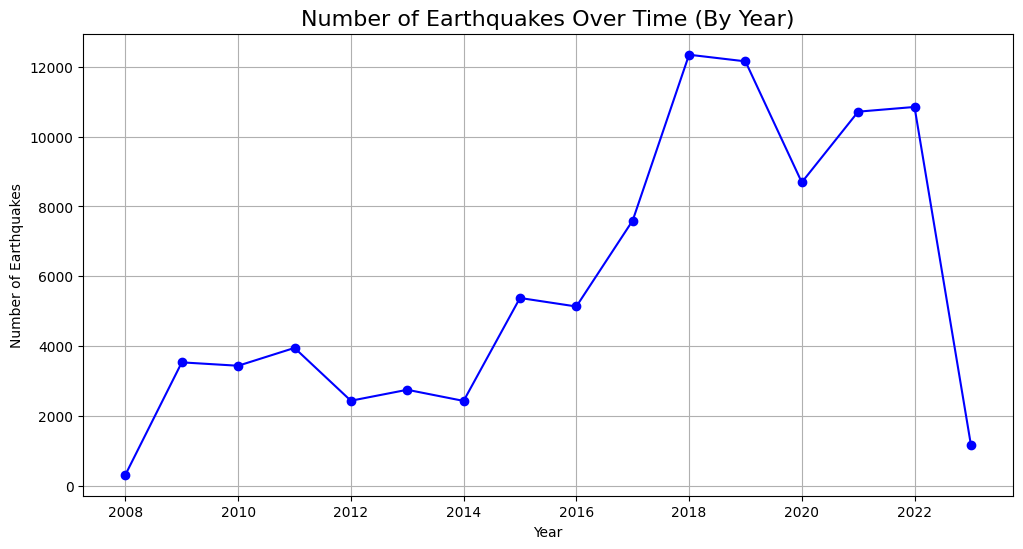

In [74]:
# Number of Earthquakes over time
data['earthquake_time'] = pd.to_datetime(data['earthquake_time'])  # Convert to datetime
data['year'] = data['earthquake_time'].dt.year  # Extract year

# Group by year and count occurrences
earthquake_counts = data.groupby('year').size()

plt.figure(figsize=(12, 6))
plt.plot(earthquake_counts.index, earthquake_counts.values, marker='o', linestyle='-', color='b')
plt.title('Number of Earthquakes Over Time (By Year)', fontsize=16)
plt.xlabel('Year')
plt.ylabel('Number of Earthquakes')
plt.grid(True)
plt.show()

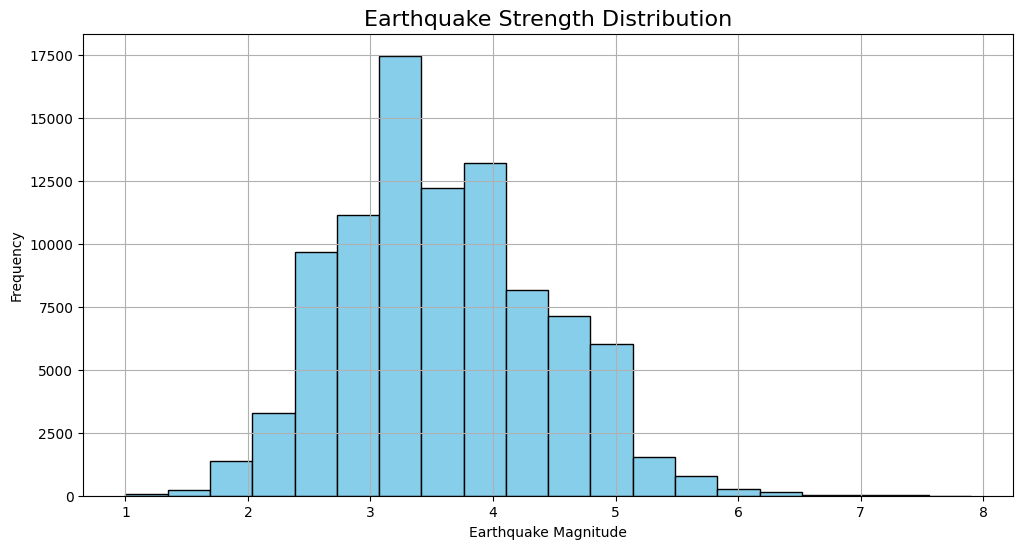

In [75]:
# Earthquake Magnitude Distribution
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
plt.hist(data['earthquake_magnitude'], bins=20, edgecolor='black', color='skyblue')
plt.title('Earthquake Strength Distribution', fontsize=16)
plt.xlabel('Earthquake Magnitude')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()



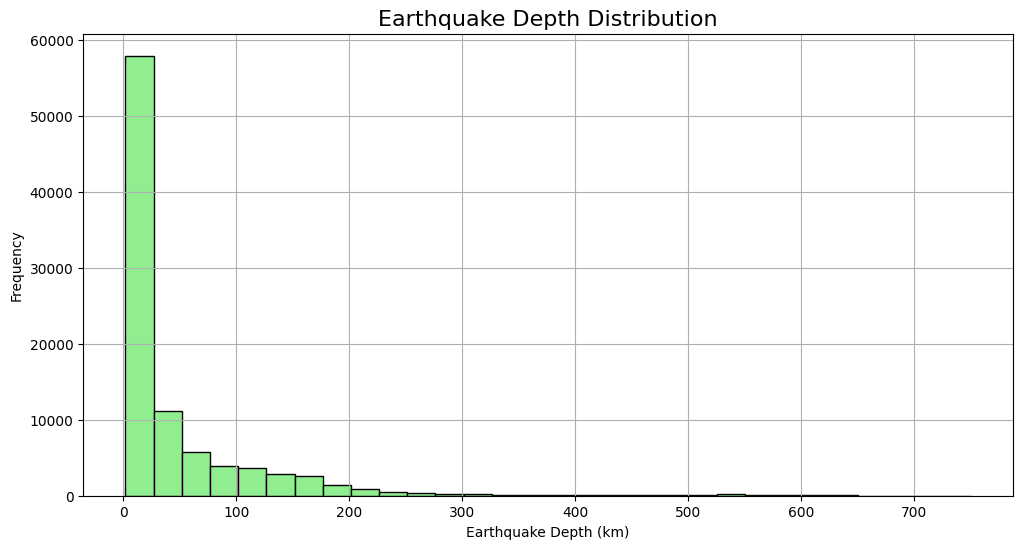

In [76]:
# Earthquake Depth Distribution
plt.figure(figsize=(12, 6))
plt.hist(data['earthquake_depth'], bins=30, edgecolor='black', color='lightgreen')
plt.title('Earthquake Depth Distribution', fontsize=16)
plt.xlabel('Earthquake Depth (km)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()



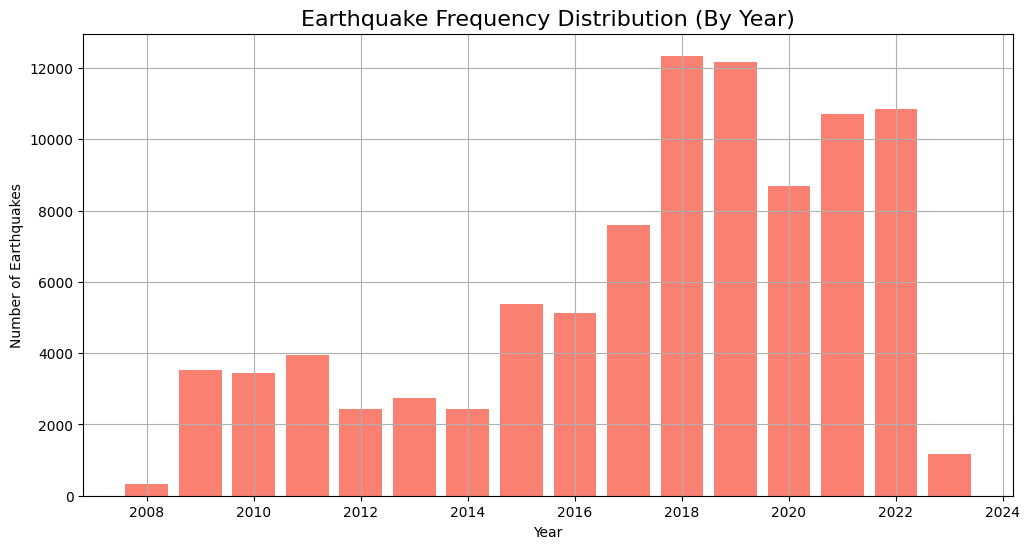

In [77]:
# Distribution of Earthquakes every year
plt.figure(figsize=(12, 6))
earthquake_counts = data.groupby('year').size()
plt.bar(earthquake_counts.index, earthquake_counts.values, color='salmon')
plt.title('Earthquake Frequency Distribution (By Year)', fontsize=16)
plt.xlabel('Year')
plt.ylabel('Number of Earthquakes')
plt.grid(True)
plt.show()


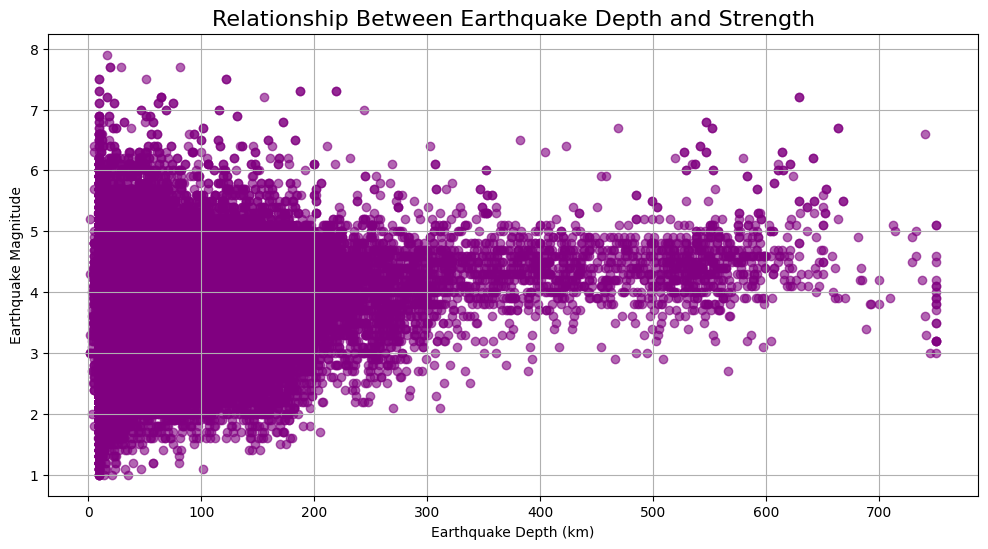

In [78]:
# Relationship between Earthquake Depth and Magnitude

plt.figure(figsize=(12, 6))
plt.scatter(data['earthquake_depth'], data['earthquake_magnitude'], alpha=0.6, color='purple')
plt.title('Relationship Between Earthquake Depth and Strength', fontsize=16)
plt.xlabel('Earthquake Depth (km)')
plt.ylabel('Earthquake Magnitude')
plt.grid(True)
plt.show()


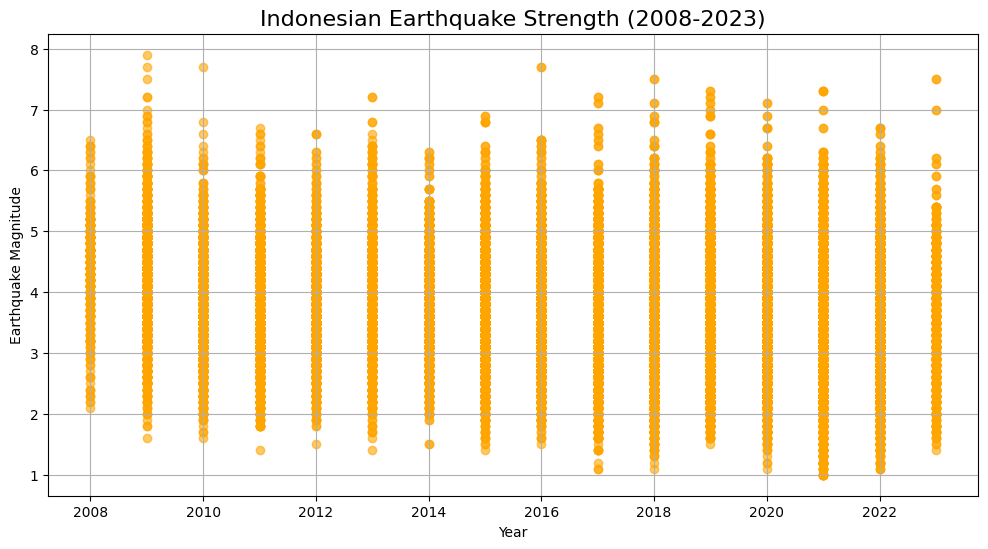

In [79]:
#Indonesian Earthquake Strength 2008-2023
data_filtered = data[(data['year'] >= 2008) & (data['year'] <= 2023)]

plt.figure(figsize=(12, 6))
plt.scatter(data_filtered['year'], data_filtered['earthquake_magnitude'], alpha=0.6, color='orange')
plt.title('Indonesian Earthquake Strength (2008-2023)', fontsize=16)
plt.xlabel('Year')
plt.ylabel('Earthquake Magnitude')
plt.grid(True)
plt.show()


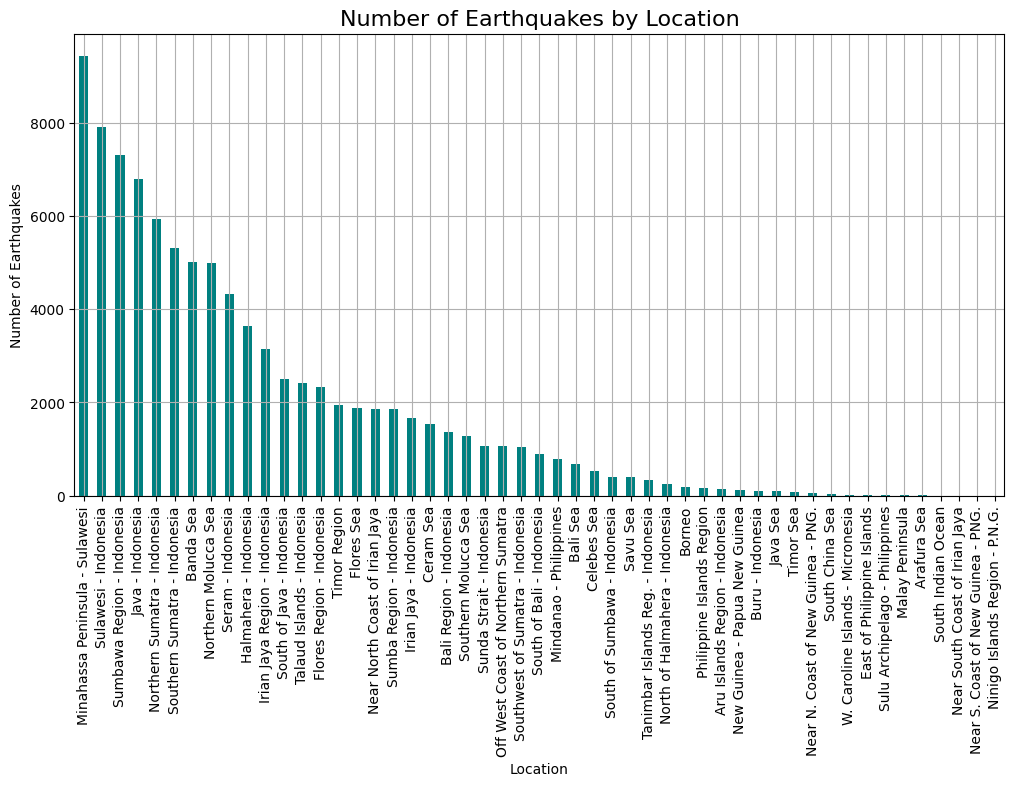

In [80]:
# Number of Earthquakes Based on Location

location_counts = data['earthquake_location'].value_counts()

plt.figure(figsize=(12, 6))
location_counts.plot(kind='bar', color='teal')
plt.title('Number of Earthquakes by Location', fontsize=16)
plt.xlabel('Location')
plt.ylabel('Number of Earthquakes')
plt.xticks(rotation=90)
plt.grid(True)
plt.show()


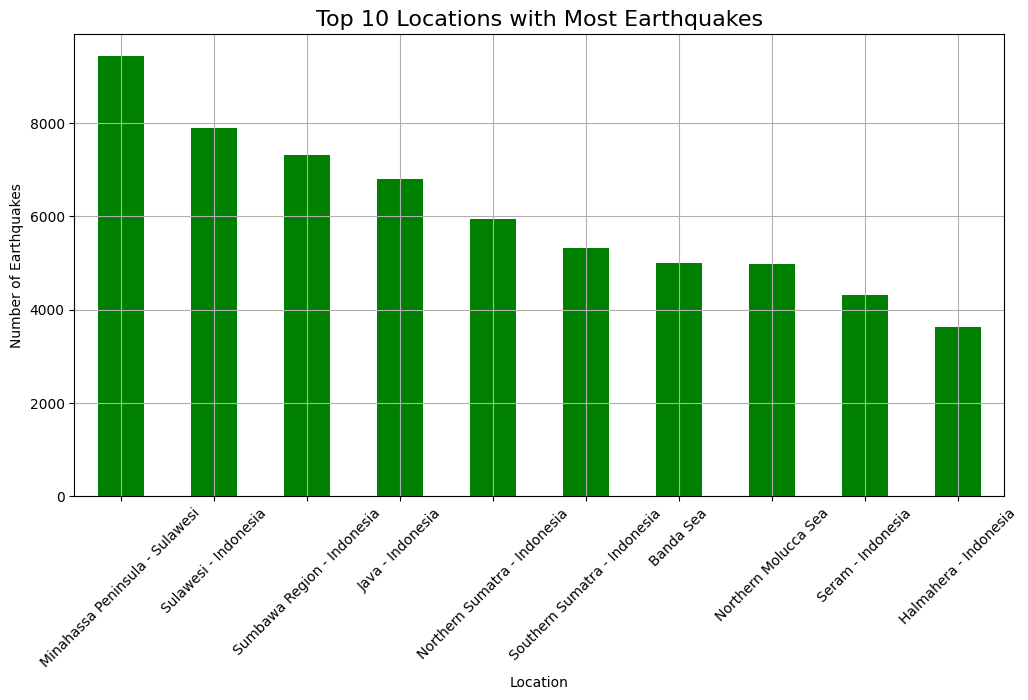

In [81]:
#Top 10 Locations Where Earthquakes Occur Most Often

top_10_locations = location_counts.head(10)

plt.figure(figsize=(12, 6))
top_10_locations.plot(kind='bar', color='green')
plt.title('Top 10 Locations with Most Earthquakes', fontsize=16)
plt.xlabel('Location')
plt.ylabel('Number of Earthquakes')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


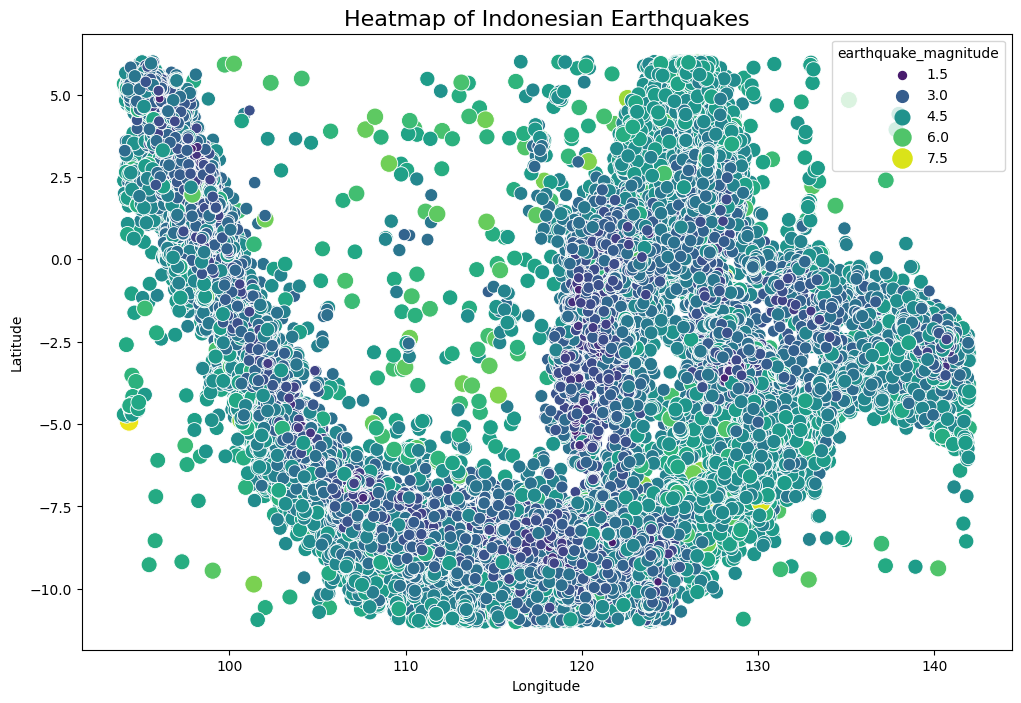

In [82]:
# Heatmap of Indonesian Earthquakes
import seaborn as sns
import numpy as np

plt.figure(figsize=(12, 8))
sns.scatterplot(x='longitude', y='latitude', data=data, hue='earthquake_magnitude', palette='viridis', size='earthquake_magnitude', sizes=(20, 200))
plt.title('Heatmap of Indonesian Earthquakes', fontsize=16)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()


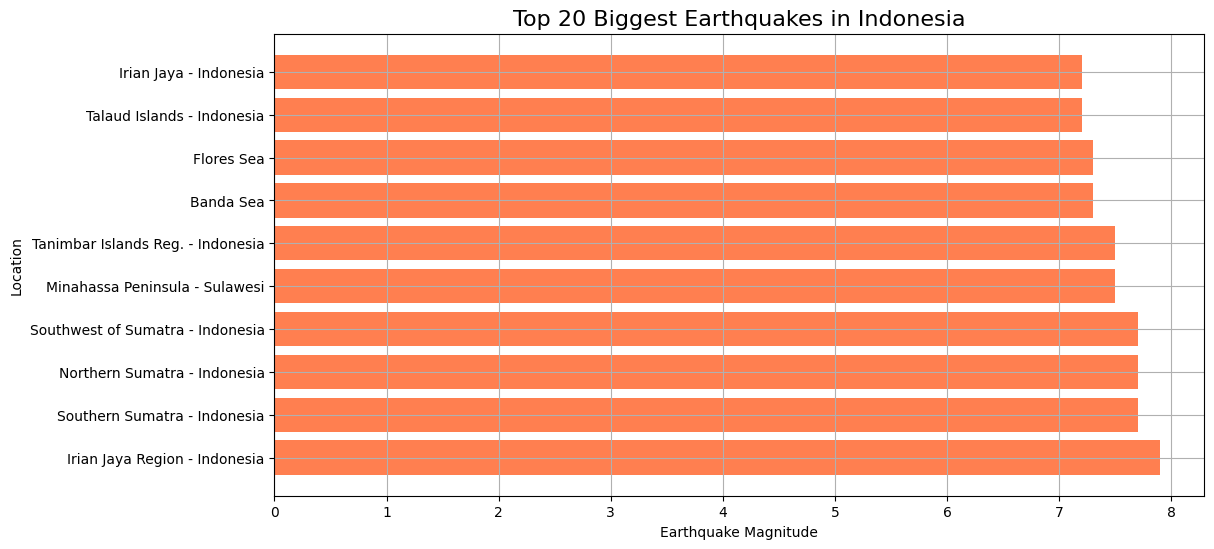

In [83]:
# Top 20 Earthquakes in Indonesia
top_20_earthquakes = data.nlargest(20, 'earthquake_magnitude')

plt.figure(figsize=(12, 6))
plt.barh(top_20_earthquakes['earthquake_location'], top_20_earthquakes['earthquake_magnitude'], color='coral')
plt.title('Top 20 Biggest Earthquakes in Indonesia', fontsize=16)
plt.xlabel('Earthquake Magnitude')
plt.ylabel('Location')
plt.grid(True)
plt.show()


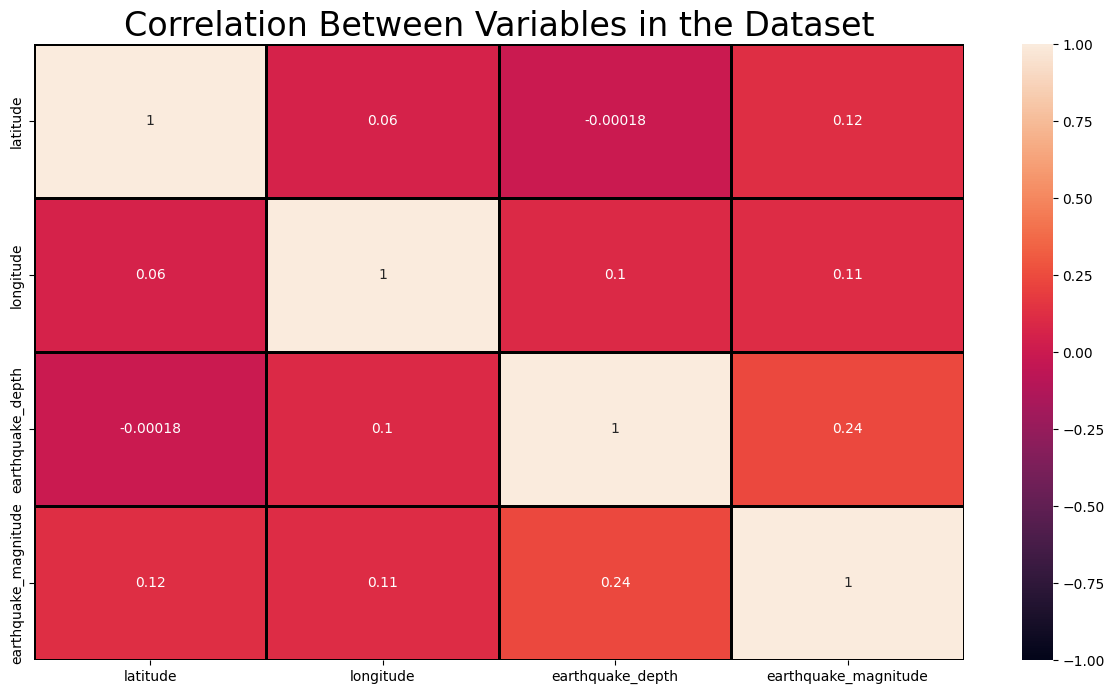

In [34]:
# Select only numerical columns
numeric_data = data.select_dtypes(include=[float, int])

# Calculate correlation and plot heatmap
plt.figure(figsize=(15, 8))
correlation = sns.heatmap(numeric_data.corr(), vmin=-1, vmax=1, annot=True, linewidths=1, linecolor='black')
correlation.set_title('Correlation Between Variables in the Dataset', fontdict={'fontsize': 24})
plt.show()


In [35]:
# Split the earthquake time column into date and time
data['date'], data['time'] = zip(*[(d.date(), d.time()) for d in data['earthquake_time']])

In [36]:
data.head()

,earthquake_time,latitude,longitude,earthquake_depth,earthquake_magnitude,earthquake_location,date,time
0,2008-11-01 21:02:43.058,-9.18,119.06,10,4.9,Sumba Region - Indonesia,2008-11-01,21:02:43.058000
1,2008-11-01 20:58:50.248,-6.55,129.64,10,4.6,Banda Sea,2008-11-01,20:58:50.248000
2,2008-11-01 17:43:12.941,-7.01,106.63,121,3.7,Java - Indonesia,2008-11-01,17:43:12.941000
3,2008-11-01 16:24:14.755,-3.30,127.85,10,3.2,Seram - Indonesia,2008-11-01,16:24:14.755000
4,2008-11-01 16:20:37.327,-6.41,129.54,70,4.3,Banda Sea,2008-11-01,16:20:37.327000


In [43]:
data.tail()

,earthquake_time,latitude,longitude,earthquake_depth,earthquake_magnitude,earthquake_location,date,time
92882,2023-01-26 02:25:09.288,3.24,127.18,10,4.0,Talaud Islands - Indonesia,2023-01-26,02:25:09.288000
92883,2023-01-26 02:15:03.893,2.70,127.10,10,3.9,Northern Molucca Sea,2023-01-26,02:15:03.893000
92884,2023-01-26 01:57:08.885,-7.83,121.07,10,3.8,Flores Sea,2023-01-26,01:57:08.885000
92885,2023-01-26 01:46:21.009,3.00,127.16,10,4.1,Northern Molucca Sea,2023-01-26,01:46:21.009000
92886,2023-01-26 00:00:35.181,-8.87,118.95,10,2.4,Sumbawa Region - Indonesia,2023-01-26,00:00:35.181000


In [38]:
# Creating a new dataset
data0 = data.fillna('N')  # Fill missing values with 'N'
data1 = data0[['date', 'latitude', 'longitude', 'earthquake_depth', 'earthquake_magnitude']]  # Select specific columns
data1  # Display the new dataset


,date,latitude,longitude,earthquake_depth,earthquake_magnitude
0,2008-11-01,-9.18,119.06,10,4.9
1,2008-11-01,-6.55,129.64,10,4.6
2,2008-11-01,-7.01,106.63,121,3.7
3,2008-11-01,-3.30,127.85,10,3.2
4,2008-11-01,-6.41,129.54,70,4.3
...,...,...,...,...,...
92882,2023-01-26,3.24,127.18,10,4.0
92883,2023-01-26,2.70,127.10,10,3.9
92884,2023-01-26,-7.83,121.07,10,3.8
92885,2023-01-26,3.00,127.16,10,4.1


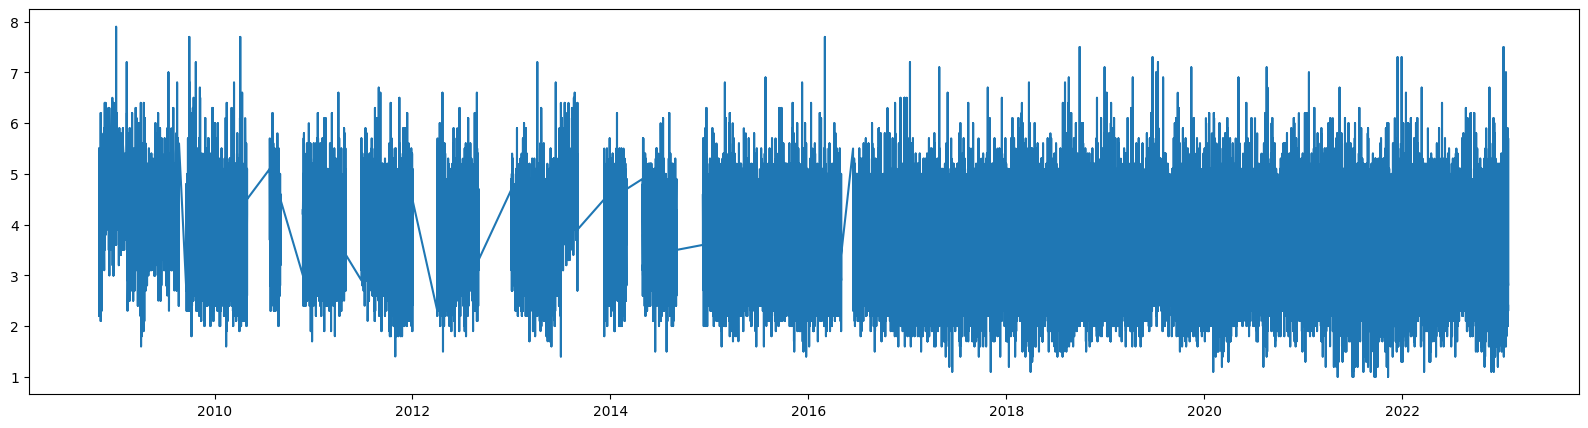

In [40]:
# Create another data for modeling
data2 = data1[['date', 'earthquake_magnitude']]

data2

item1 = data2

item1.columns = ['ds', 'y']
item1.y = item1.y.astype('float')
item1.ds = item1.ds.astype('datetime64[ns]')

rcParams['figure.figsize'] = 20, 5
plt.plot(item1.ds, item1.y)

17:18:29 - cmdstanpy - INFO - Chain [1] start processing
17:19:01 - cmdstanpy - INFO - Chain [1] done processing
/opt/conda/lib/python3.10/site-packages/prophet/plot.py:72: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result

/opt/conda/lib/python3.10/site-packages/prophet/plot.py:73: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



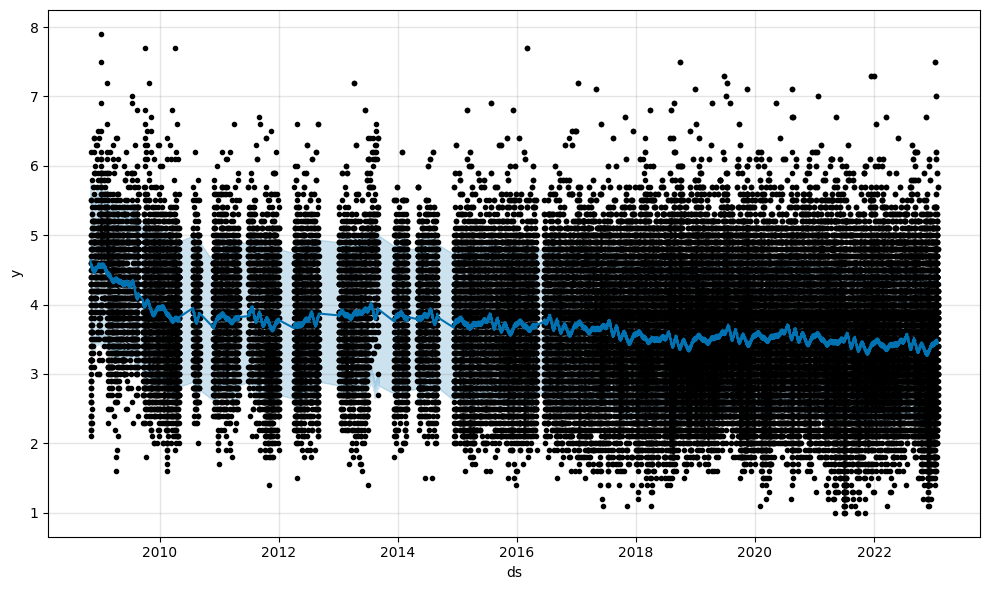

In [42]:
"""## Forecasting Using Prophet"""

# Fit Prophet Model
# Initialize the Prophet model
ph = Prophet()

# Fit the model to the dataset
ph.fit(item1)

# Make predictions (forecasting future values)
forecast1 = ph.predict(item1)

# Plot the forecasted results
figure = ph.plot(forecast1)

# Display the plot
figure.show()

**Previous + Future Data Prediction and Past Data Fit**

In [46]:
from datetime import timedelta
# Define the start and end dates
start0 = dt.datetime.strptime('2023-01-27', '%Y-%m-%d').date()
end0   = dt.datetime.strptime('2026-12-31', '%Y-%m-%d').date()

# Calculate the difference in days between the two dates
print((end0 - start0).days)


1434


In [48]:
def daterange(start,end):
    for i in range((end-start).days):
        return start+timedelta(i)

In [50]:
dates0=[]
for i in range((end0-start0).days):
    dates0+=[(start0+timedelta(i)).strftime('%Y-%m-%d') ]
print(dates0[0:30])

['2023-01-27', '2023-01-28', '2023-01-29', '2023-01-30', '2023-01-31', '2023-02-01', '2023-02-02', '2023-02-03', '2023-02-04', '2023-02-05', '2023-02-06', '2023-02-07', '2023-02-08', '2023-02-09', '2023-02-10', '2023-02-11', '2023-02-12', '2023-02-13', '2023-02-14', '2023-02-15', '2023-02-16', '2023-02-17', '2023-02-18', '2023-02-19', '2023-02-20', '2023-02-21', '2023-02-22', '2023-02-23', '2023-02-24', '2023-02-25']


In [51]:
dates0_df=pd.DataFrame(dates0)
dates0_df.columns=['ds']
dates0_df

,ds
0,2023-01-27
1,2023-01-28
2,2023-01-29
3,2023-01-30
4,2023-01-31
...,...
1429,2026-12-26
1430,2026-12-27
1431,2026-12-28
1432,2026-12-29


17:41:02 - cmdstanpy - INFO - Chain [1] start processing
17:41:35 - cmdstanpy - INFO - Chain [1] done processing
/opt/conda/lib/python3.10/site-packages/prophet/plot.py:72: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result

/opt/conda/lib/python3.10/site-packages/prophet/plot.py:73: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



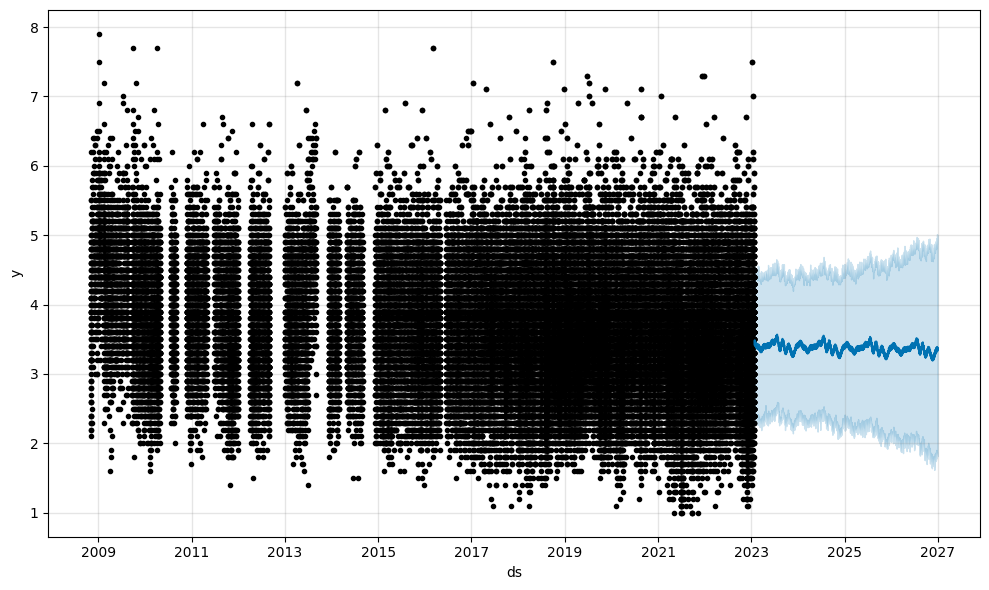

In [53]:
ph = Prophet()
ph.fit(item1)
forecast3=ph.predict(dates0_df)
figure = ph.plot(forecast3)
figure.show()

In [54]:
forecast3[['ds','yhat','yhat_lower','yhat_upper']][339:704]#['yhat'].max()

,ds,yhat,yhat_lower,yhat_upper
339,2024-01-01,3.383862,2.270962,4.378031
340,2024-01-02,3.406921,2.348212,4.513084
341,2024-01-03,3.424904,2.363293,4.451442
342,2024-01-04,3.403684,2.395339,4.513707
343,2024-01-05,3.386666,2.367084,4.410093
...,...,...,...,...
699,2024-12-26,3.378268,2.277756,4.469168
700,2024-12-27,3.360340,2.271069,4.451038
701,2024-12-28,3.424753,2.244171,4.546816
702,2024-12-29,3.403754,2.325203,4.585716


In [57]:

forecast4=forecast3[['ds','yhat','yhat_lower','yhat_upper']][339:704*2]
forecast4.to_csv('/kaggle/working/forecast_earthquake_strength.csv')

* ds: This is the date for each forecasted entry. It corresponds to the dates for which the model has generated predictions.

* yhat: This is the model's predicted value for earthquake magnitude on each date in ds. It's the main output of the model and represents the expected value of earthquake magnitude as per the forecast.

* yhat_lower: This is the lower bound of the prediction interval for yhat. It indicates the lowest value that the earthquake magnitude is likely to take on a particular date, based on the model's confidence interval. This gives an idea of the potential variation or uncertainty in the prediction on the lower side.

* yhat_upper: This is the upper bound of the prediction interval for yhat

Prediction of Maximum Earthquake Strength During 2024

In [58]:
mag0=forecast3[339:1434*2]['yhat'].max()
print(mag0)

3.5519744604165435


In [59]:
forecast3[forecast3['yhat']==mag0]

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
540,2024-07-20,3.381355,2.533897,4.686953,3.128949,3.602838,0.170619,0.170619,0.170619,0.035853,0.035853,0.035853,0.134767,0.134767,0.134767,0.0,0.0,0.0,3.551974


In [60]:
from sklearn.metrics import mean_squared_error

# The actual earthquake data
actual_data = item1[['ds', 'y']]

# The forecasted data for the same dates as in `item1`
predicted_data = forecast1[['ds', 'yhat']]

# Merge actual and predicted data on 'ds' to align them by date
comparison_df = actual_data.merge(predicted_data, on='ds', how='inner')

# Calculate MSE between the actual and predicted earthquake magnitudes
mse = mean_squared_error(comparison_df['y'], comparison_df['yhat'])
print("Mean Squared Error (MSE):", mse)


Mean Squared Error (MSE): 0.6830152425096936


* Prediction Analysis Conclusion
Based on the results of the analysis and predictions, it can be concluded that:

* The number of earthquakes increased quite drastically from 2008 to 2020, but the number of earthquakes that occurred from 2021 to 2023 was fairly constant.

* On average, earthquakes that occurred from 2008 to 2023 had a magnitude of 2 to 5. Only a few earthquakes occurred with SR 6 to 7.

* Most earthquakes in Indonesia are less than 100 km deep

* The number of earthquakes that occur every year has increased quite significantly

* The number of locations where earthquakes frequently occur are Minahasa Peninsula, Sulawesi, Sumbawa, Java, North of Sumatra Island, South of Sumatra Island, Banda Sea, Halmahera, Irian Jaya and South of Java Island.

* The largest earthquake occurred in 2009 in Irian Jaya with a magnitude of 7.9 SR and an earthquake with a magnitude of 7.7 SR occurred in 2009 in the South of Sumatra Island, in 2020 in the North of Sumatra Island and in 2016 in the Southwest of Sulawesi Island

* The predicted strength of earthquakes in Indonesia until 2026 is no more than 5 on the Richter scale

* The predicted strength of the earthquake in Indonesia will be the highest for the next 1 year in 2024, namely 3.6 on the Richter scale